In [ ]:
import os
import pandas as pd
import torch
from torchvision import models
from utils import DRDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
import numpy as np

DESC = 'resnet'
if not os.path.exists(f'../results/{DESC}'):
    os.makedirs(f'../results/{DESC}')
    
#load labels
labels = pd.read_csv('../data/trainLabels.csv')

NUM_CLASSES = len(labels['level'].unique())
LABELS_MAP = ['0-No DR', '1-Mild', '2-Moderate', '3-Severe', '4-Proliferative DR']
BATCH_SIZE = 32

# split into train/val/test using stratified sampling (70/10/20)
# TODO --> use torch to split all at once?
labels_train, labels_test = train_test_split(labels, test_size=0.3, stratify=labels['level'], random_state=42)
labels_val, labels_test = train_test_split(labels_test, test_size=2/3, stratify=labels_test['level'], random_state=42)

# # Apply SMOTE on the training labels (to balance classes) --> will not work on img path strings
# # TODO: consider using image embeddings or data augmentation
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(labels_train['image'], labels_train['level'])

# # Resample using RandomOverSampler
# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(labels_train[['image']], labels_train['level'])
# labels_train_resampled = pd.DataFrame({'image': X_train_resampled['image'], 'level': y_train_resampled})

# Create dataset objects using the resampled labels
train_data = DRDataset(labels_train, '../data/preproc_train_imgs.pt',
                       preproc=models.ResNet50_Weights.DEFAULT.transforms())
val_data = DRDataset(labels_val, '../data/preproc_train_imgs.pt',
                     preproc=models.ResNet50_Weights.DEFAULT.transforms())
test_data = DRDataset(labels_test, '../data/preproc_train_imgs.pt',
                      preproc=models.ResNet50_Weights.DEFAULT.transforms())


#Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

#dataset size checks
train_N = len(train_loader.dataset)
val_N = len(val_loader.dataset)
test_N = len(test_loader.dataset)

train_N, val_N, test_N

(24588, 3512, 7026)

In [ ]:
# # TODO: make this pretty
# print('before resampling')
# print(len(labels_train), len(labels_val), len(labels_test))
# print(len(labels_train)/len(labels), len(labels_val)/len(labels), len(labels_test)/len(labels))
# print(labels_train['level'].value_counts(normalize=True).sort_index(), labels_val['level'].value_counts(normalize=True).sort_index(), labels_test['level'].value_counts(normalize=True).sort_index())
# print()
# print('after resampling')
# print(len(labels_train_resampled), len(labels_val), len(labels_test))
# print(labels_train_resampled['level'].value_counts(normalize=True).sort_index(), labels_val['level'].value_counts(normalize=True).sort_index(), labels_test['level'].value_counts(normalize=True).sort_index())

before resampling
24588 3512 7026
0.6999943062119228 0.09998291863576837 0.20002277515230882
level
0    0.734789
1    0.069546
2    0.150643
3    0.024850
4    0.020172
Name: proportion, dtype: float64 level
0    0.734909
1    0.069476
2    0.150626
3    0.024772
4    0.020216
Name: proportion, dtype: float64 level
0    0.734700
1    0.069599
2    0.150726
3    0.024907
4    0.020068
Name: proportion, dtype: float64

after resampling


NameError: name 'labels_train_resampled' is not defined

In [3]:
# load resnet
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# freeze weights
resnet.requires_grad_(False)
# adjust last layer for binary classification
resnet.fc = torch.nn.Linear(resnet.fc.in_features, NUM_CLASSES)
resnet.fc.requires_grad_(True)

# print model summary
from torchinfo import summary
summary(resnet, input_size=next(resnet.parameters()).size())

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 5]                   --
├─Conv2d: 1-1                            [64, 64, 4, 4]            (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 4, 4]            (128)
├─ReLU: 1-3                              [64, 64, 4, 4]            --
├─MaxPool2d: 1-4                         [64, 64, 2, 2]            --
├─Sequential: 1-5                        [64, 256, 2, 2]           --
│    └─Bottleneck: 2-1                   [64, 256, 2, 2]           --
│    │    └─Conv2d: 3-1                  [64, 64, 2, 2]            (4,096)
│    │    └─BatchNorm2d: 3-2             [64, 64, 2, 2]            (128)
│    │    └─ReLU: 3-3                    [64, 64, 2, 2]            --
│    │    └─Conv2d: 3-4                  [64, 64, 2, 2]            (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 2, 2]            (128)
│    │    └─ReLU: 3-6                    [64, 64, 2, 2]     

In [4]:
# compile model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(DEVICE)
loss_fn = torch.nn.CrossEntropyLoss() # expects logits
optimizer = torch.optim.Adam(resnet.parameters())

# train
EPOCHS = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = torch.inf
for epoch in range(EPOCHS):
    # train
    resnet.train()
    running_loss = 0.0
    running_correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    # val
    resnet.eval()
    running_vloss = 0.0
    running_vcorrect = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = resnet(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss.item()
            running_vcorrect += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()

    print(f"Epoch {epoch+1}/{EPOCHS}\t" +
          f"Train Loss: {running_loss/train_N:.4f} | Train Acc: {running_correct/train_N:.4f} | " +
          f"Val Loss: {running_vloss/val_N:.4f} | Val Acc: {running_vcorrect/val_N:.4f}")

    train_losses.append(running_loss/train_N)
    val_losses.append(running_vloss/val_N)
    train_accs.append(running_correct/train_N)
    val_accs.append(running_vcorrect/val_N)

    # save best model
    if running_vloss < best_val_loss:
        best_val_loss = running_vloss
        torch.save(resnet, f'../results/{DESC}/model.pth')

# evaluate
# load best model
resnet = torch.load(f'../results/{DESC}/model.pth', weights_only=False).to(DEVICE)
resnet.eval()
correct = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(inputs)
        correct += (torch.softmax(outputs, dim=1).argmax(dim=1) == labels).sum().item()
print()
print(f'Test Accuracy: {correct/test_N:.4f}')

Epoch 1/100	Train Loss: 0.0254 | Train Acc: 0.7389 | Val Loss: 0.0239 | Val Acc: 0.7429
Epoch 2/100	Train Loss: 0.0234 | Train Acc: 0.7481 | Val Loss: 0.0234 | Val Acc: 0.7494
Epoch 3/100	Train Loss: 0.0226 | Train Acc: 0.7537 | Val Loss: 0.0235 | Val Acc: 0.7509
Epoch 4/100	Train Loss: 0.0221 | Train Acc: 0.7585 | Val Loss: 0.0231 | Val Acc: 0.7537
Epoch 5/100	Train Loss: 0.0217 | Train Acc: 0.7594 | Val Loss: 0.0231 | Val Acc: 0.7509
Epoch 6/100	Train Loss: 0.0216 | Train Acc: 0.7601 | Val Loss: 0.0231 | Val Acc: 0.7500
Epoch 7/100	Train Loss: 0.0214 | Train Acc: 0.7619 | Val Loss: 0.0232 | Val Acc: 0.7489
Epoch 8/100	Train Loss: 0.0212 | Train Acc: 0.7633 | Val Loss: 0.0233 | Val Acc: 0.7494
Epoch 9/100	Train Loss: 0.0210 | Train Acc: 0.7657 | Val Loss: 0.0235 | Val Acc: 0.7509
Epoch 10/100	Train Loss: 0.0209 | Train Acc: 0.7669 | Val Loss: 0.0233 | Val Acc: 0.7560
Epoch 11/100	Train Loss: 0.0208 | Train Acc: 0.7658 | Val Loss: 0.0239 | Val Acc: 0.7548
Epoch 12/100	Train Loss: 0.020

In [ ]:
# save datasets, optimizer state, and metrics to metadata file
torch.save({'train_data': train_data,
            'val_data': val_data,
            'test_data': test_data,
            'optimizer_state': optimizer.state_dict(),
            'metrics': pd.DataFrame({'train_loss': train_losses,
                                     'val_loss': val_losses,
                                     'train_acc': train_accs,
                                     'val_acc': val_accs})},
            
            f'../results/{DESC}/metadata.pth')

# training curves

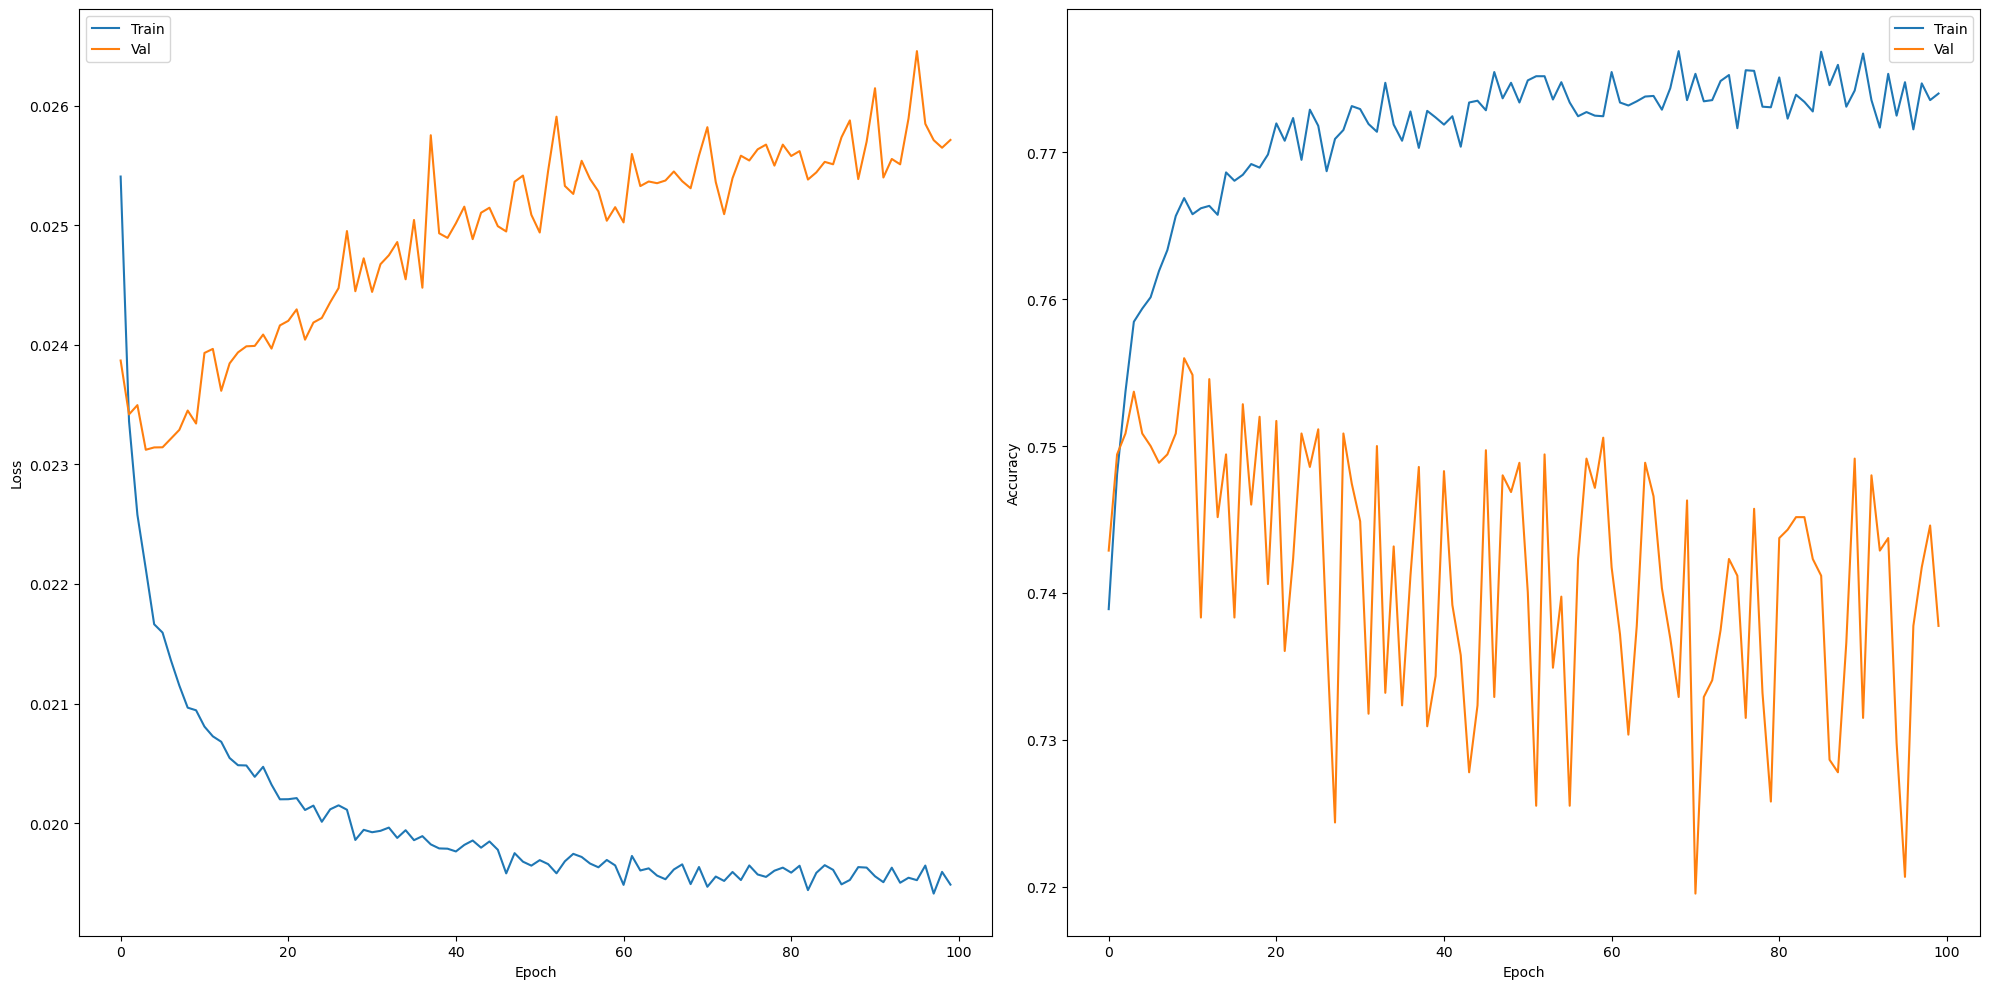

In [6]:
# plot training curves
import matplotlib.pyplot as plt

# losses
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig(f'../results/{DESC}/training_curves_{EPOCHS}epochs.png')
plt.show()

# confusion matrix

In [ ]:
# test set results (~15min/1s if images are loaded/not loaded in memory)
resnet.eval()

y_true = []
y_logit = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = resnet(inputs)
        y_true.extend(labels.cpu().numpy())
        y_logit.extend(outputs.cpu().numpy())
        y_pred.extend(torch.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy())

y_true = np.array(y_true)
y_logit = np.array(y_logit)
y_pred = np.array(y_pred)
np.savez(f'../results/{DESC}/test_results.npz', y_true=y_true, y_logit=y_logit, y_pred=y_pred)

                    precision    recall  f1-score   support

           0-No DR       0.78      0.97      0.86      5162
            1-Mild       0.00      0.00      0.00       489
        2-Moderate       0.43      0.21      0.28      1059
          3-Severe       0.41      0.07      0.12       175
4-Proliferative DR       0.47      0.19      0.27       141

          accuracy                           0.75      7026
         macro avg       0.42      0.29      0.31      7026
      weighted avg       0.66      0.75      0.69      7026



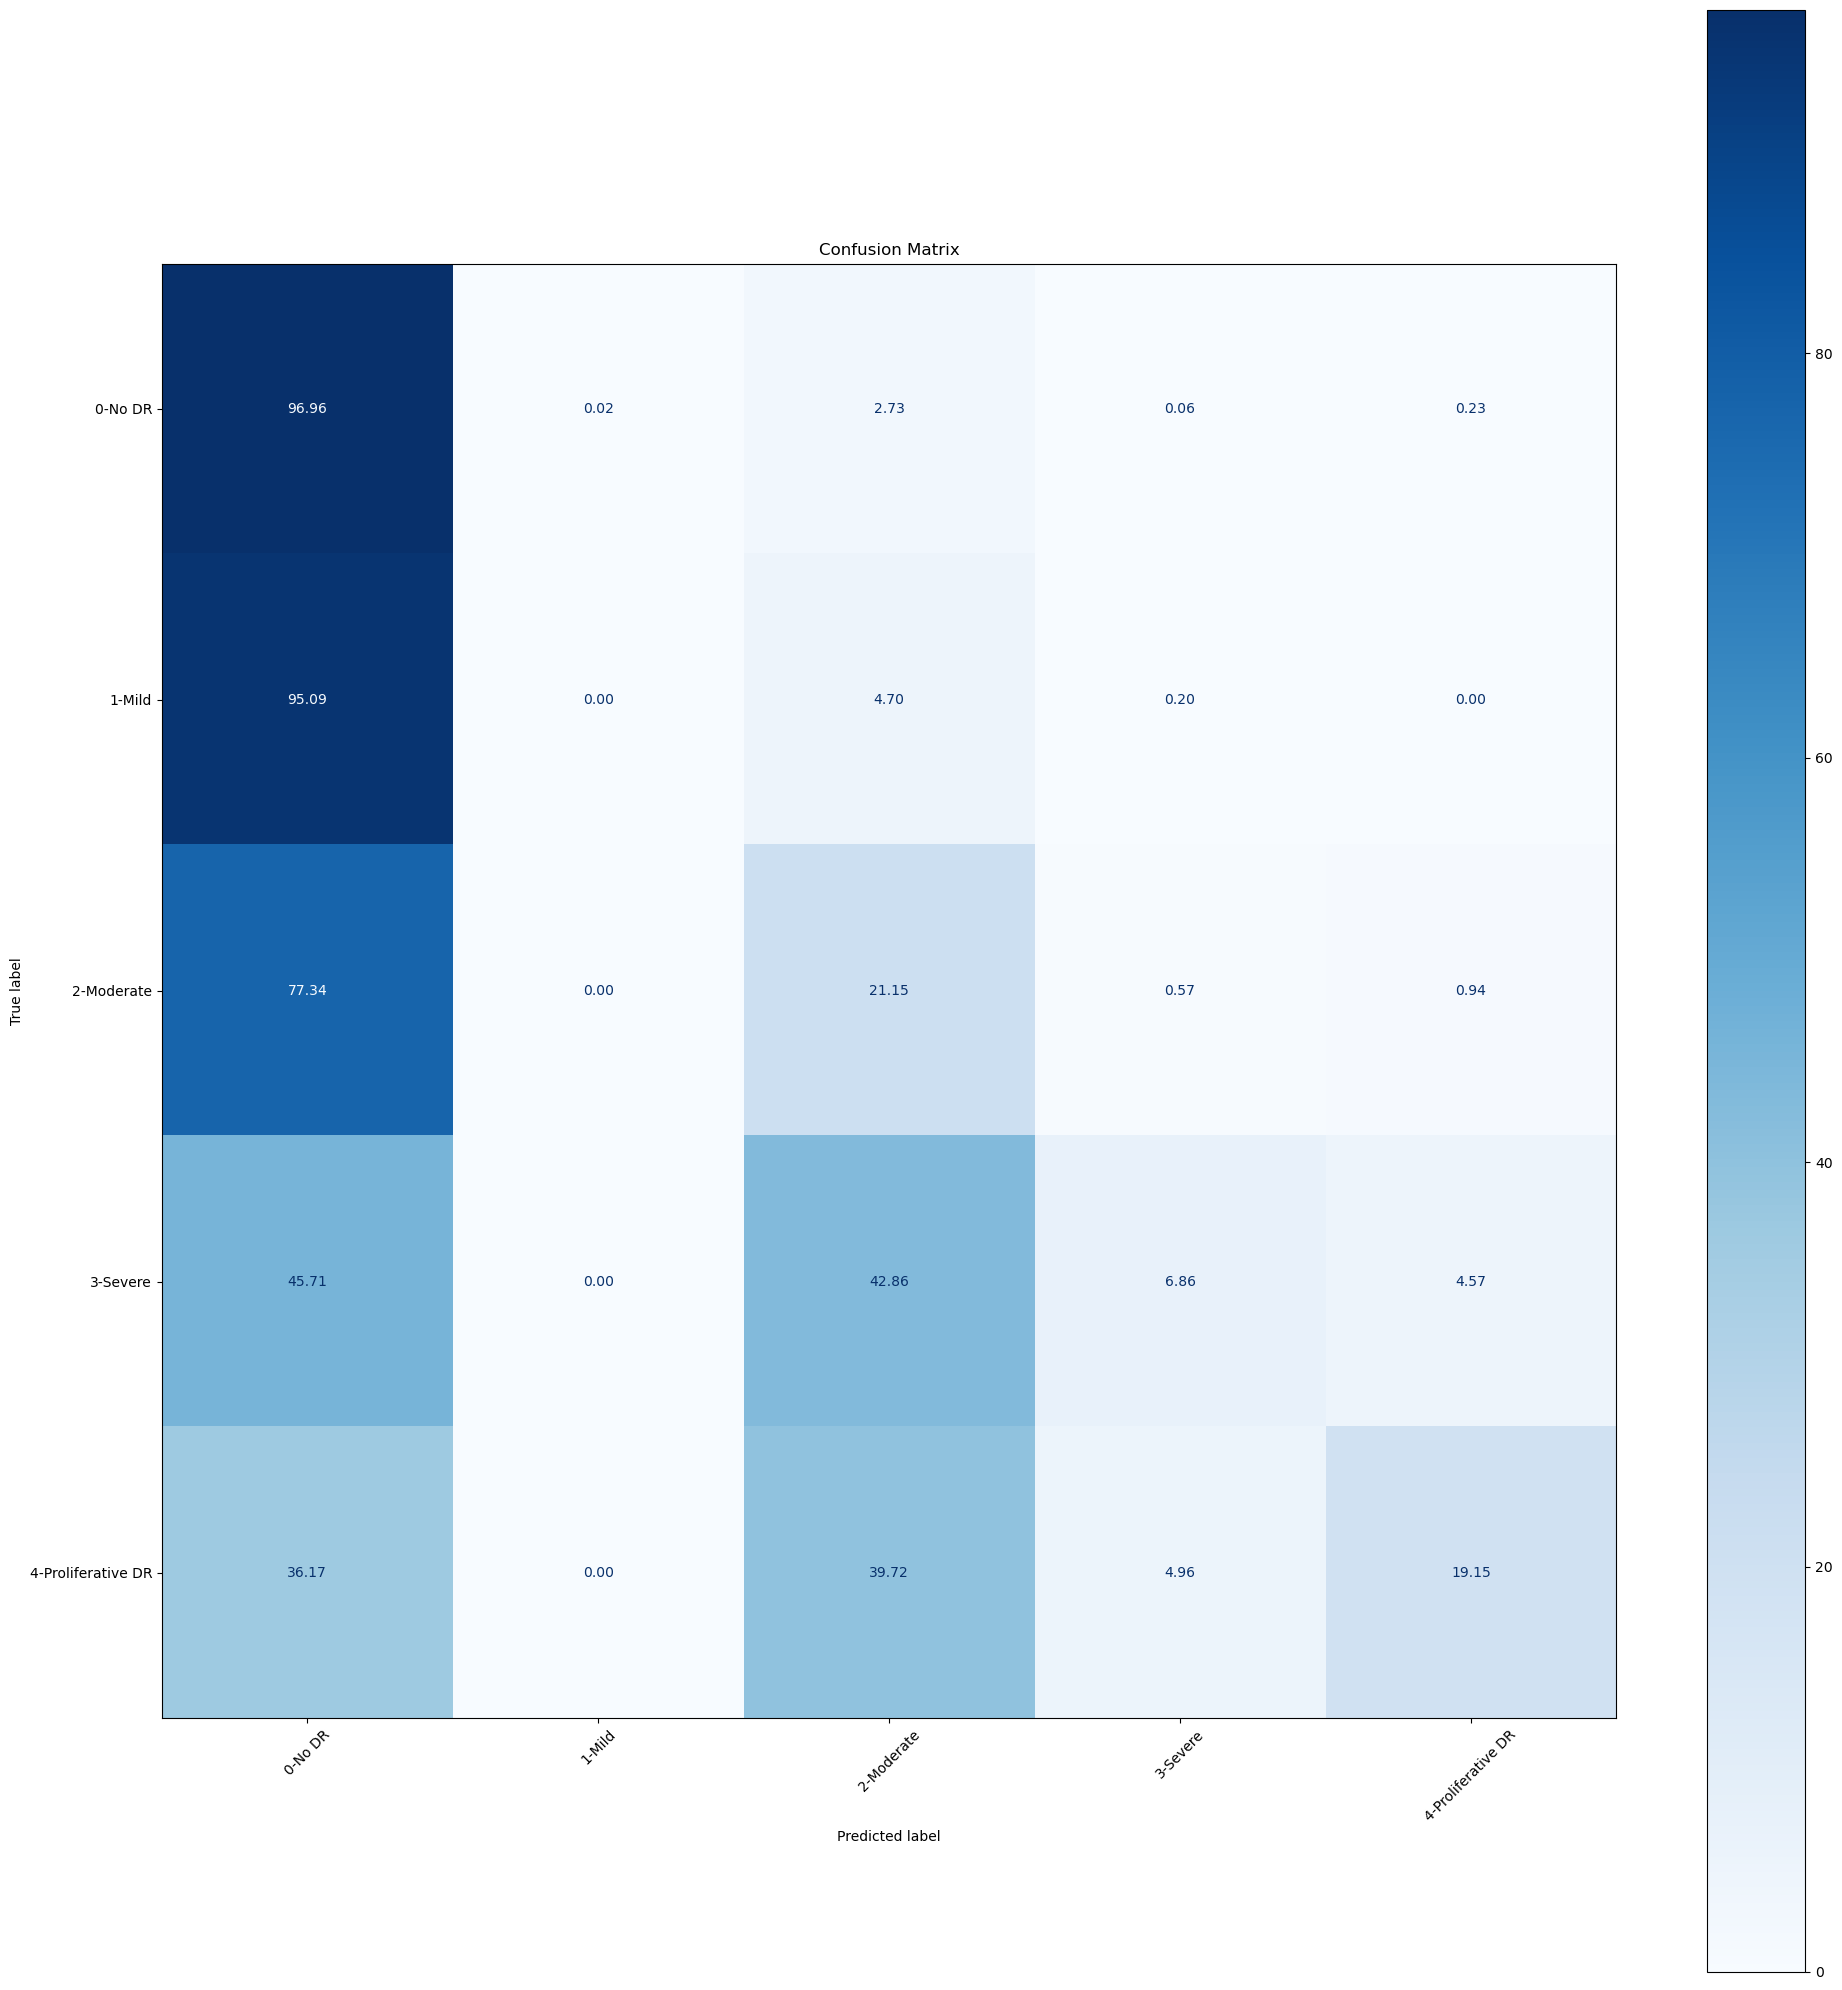

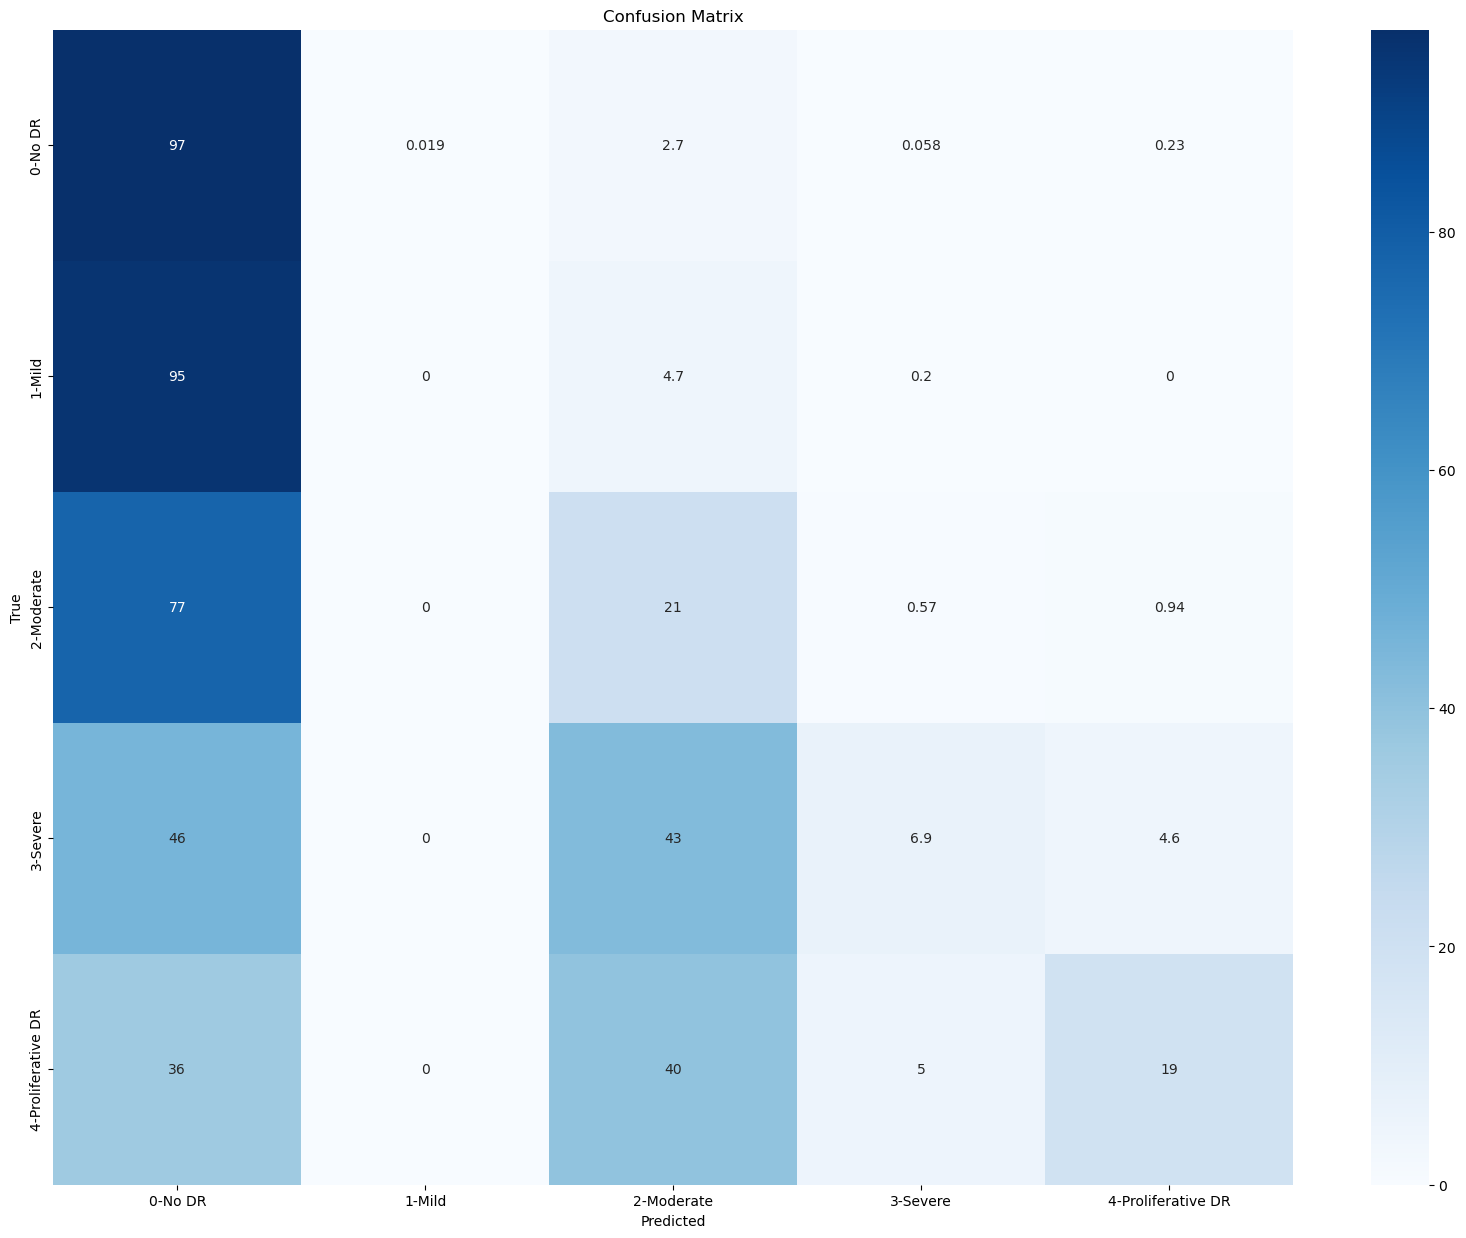

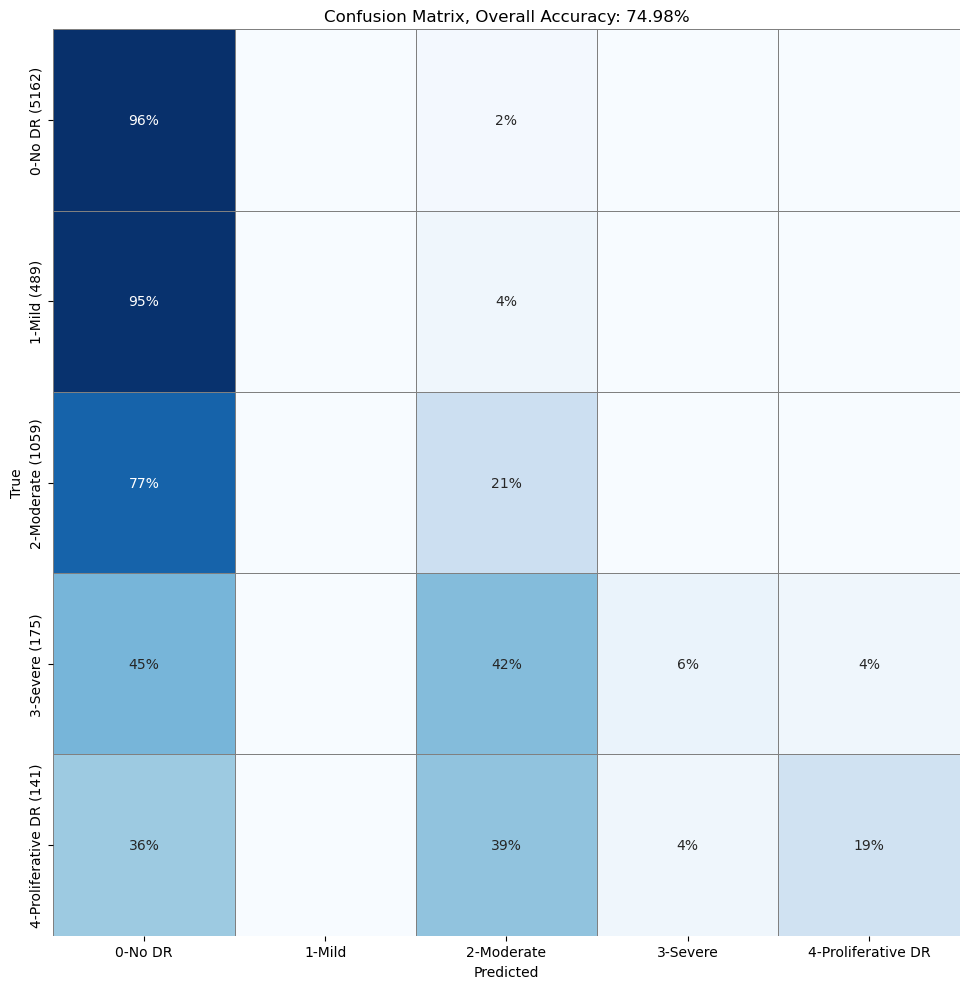

In [8]:
# TODO: clean this up

'''
CLASSIFICATION REPORT AND CONFUSIONMATRIXDISPLAY
'''
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_true, y_pred, labels=range(NUM_CLASSES), target_names=LABELS_MAP, zero_division=0))

cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_MAP)
# plot on large figure
fig, ax = plt.subplots(figsize=(20,20))
disp.plot(xticks_rotation = 45, values_format = '.2f', ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

'''
SIMPLE CONFUSION MATRIX
'''
# confusion matrix for test set
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# simple
cm = 100*confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=LABELS_MAP,
            yticklabels=LABELS_MAP)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

'''
CLEARER CONFUSION MATRIX (saved)
'''
# Compute normalized confusion matrix (row-wise normalization)
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES), normalize='true')

# Convert to integer percentages (whole numbers for clarity)
cm_percent = (cm * 100).astype(int)

# Get the number of true labels per class
true_counts = np.bincount(y_true, minlength=NUM_CLASSES)

# Create annotation labels: format as integer percentages, hide 0%
annot_labels = np.empty_like(cm_percent, dtype=object)
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        if cm_percent[i, j] > 0:
            annot_labels[i, j] = f"{cm_percent[i, j]}%"  # No decimals
        else:
            annot_labels[i, j] = ""

# Modify y-tick labels to include true label counts
class_labels = LABELS_MAP
yticklabels_with_counts = [f"{label} ({true_counts[i]})" for i, label in enumerate(class_labels)]

# Plot the heatmap in YOLO style
plt.figure(figsize=(12, 10))  # Adjust figure size for readability
sns.heatmap(cm_percent, annot=annot_labels, fmt='', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=yticklabels_with_counts,  # Updated y-tick labels
            linewidths=0.5, linecolor='gray', square=True, cbar=False)  # Clean grid layout

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix, Overall Accuracy: {100*correct/test_N:.2f}%')
plt.tight_layout()
plt.savefig(f'../results/{DESC}/confusion_matrix_{EPOCHS}epochs.png')
plt.show()